# Randomization in Linear Tests 

Objective of this project is to see the impact of randomization in decimals of the Fama-French factors on the linear tests regression that is used to assess the significance of new anomalies.

By Nicolas Harvie 
***

In [35]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from scipy.stats import truncnorm
import statsmodels.formula.api as smf
import warnings

warnings.filterwarnings("ignore")

*** 
## Setup

In [36]:
LS = pd.read_csv('./data/chen_predictors.csv', parse_dates=['date'], index_col='date')

In [37]:
# Get FF 5 Factors 
FF = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3', start='1900')[0]

# Risk free rate is not a factor 
FF = FF.drop(columns={'RF'})

In [38]:
# Get the Same Index as the FF data by changing the time period 
LS.index = LS.reset_index()['date'].dt.to_period('M')

### Date Slicing

In [39]:
signal_doc = pd.read_csv('./data/signal_doc.csv', index_col='Acronym', parse_dates=['SampleStartYear', 'SampleEndYear'])

In [40]:
# Have a DF with all the ending and starting dates for the studies 
study_dates = signal_doc[['SampleStartYear', 'SampleEndYear']]

study_dates['SampleStartYear'] = pd.to_datetime(study_dates['SampleStartYear']).dt.to_period('M')
study_dates['SampleEndYear'] = pd.to_datetime(study_dates['SampleEndYear']).dt.to_period('M')

In [41]:
study_dates['SampleEndYear'] = study_dates['SampleEndYear'] + 11

In [42]:
study_dates

,SampleStartYear,SampleEndYear
Acronym,,
AbnormalAccruals,1971-01,1992-12
Accruals,1962-01,1991-12
AccrualsBM,1980-01,1998-12
Activism1,1990-01,2001-12
AM,1963-01,1990-12
...,...,...
SP_q,1979-01,1991-12
tang_q,1973-01,2001-12
Tax_q,1973-01,2000-12


***
## Core

In [43]:
def factor_regression(factor, random='default'):
    """
    Computes a linear regression using the given factor and optional random array.

    Parameters:
    factor : DataFrame
        The factor used in the regression.
    random : ndarray or str, optional
        Flag or random array. Default is 'default'.

    Returns:
    regression_result : statsmodels.regression.linear_model.RegressionResultsWrapper
        Object containing the result of the linear regression.

    Notes:
    - This function performs a linear regression using the given factor.
    - The factor is merged with the FF DataFrame based on the index.
    - If `random` is an ndarray, it is merged with the factor and FF DataFrame.
    - The merged DataFrame is then cleaned by dropping rows with missing values.
    - The merged DataFrame is sliced based on study dates from `study_dates` DataFrame.
    - The dependent variable `Y` is the last column of the merged DataFrame.
    - The independent variables `X` are all columns except the last one.
    - The linear regression model is fitted using `smf.ols` from statsmodels library.
    - The formula for the regression model is 'Y ~ 1 + X'.
    - The result of the regression model is returned.

    Example:
    factor_data = pd.DataFrame(factor_data)
    regression_result = factor_regression(factor_data, random='random_array')
    """

    
    # Merging the DataFrame
    factor = pd.DataFrame(factor)
    if type(random) == np.ndarray:
        merged_reg_df = pd.merge(FF + random, factor, left_index=True, right_index=True)
    else:
        merged_reg_df = pd.merge(FF, factor, left_index=True, right_index=True)
      
    merged_reg_df = merged_reg_df.dropna()

    # Slicing the DF according to date
    merged_reg_df = merged_reg_df[(merged_reg_df.index >= study_dates.loc[factor.columns[0], 'SampleStartYear']) & (merged_reg_df.index <= study_dates.loc[factor.columns[0], 'SampleEndYear'])]

    # Setting the Variables
    # Works with all FF specifications but factor LS must be joined second 
    X = merged_reg_df.iloc[:, :-1]
    Y = merged_reg_df.iloc[:, -1]


    reg = smf.ols('Y ~ 1 + X',data=merged_reg_df).fit()

    return reg

### Randomization

In [45]:
N = 100
random_df = pd.DataFrame(index= [i for i in range(N)], columns=LS.columns)

for factor in LS.columns:
    for i in range(N):
        random_df.at[i, factor] = factor_regression(LS[factor], 
        random=truncnorm.rvs(-0.005, 0.005, size=FF.shape)).tvalues[0]

In [61]:
range_df = pd.DataFrame(random_df.max(axis=0) - random_df.min(axis=0)).sort_values(by=[0], ascending=False)

<AxesSubplot: ylabel='Density'>

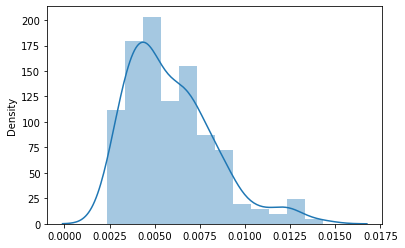

In [62]:
sns.distplot(range_df)

Where could it be most impacted (decimal being highest %)

In [ ]:
# Market Factor
FF[(FF[FF.columns[0]] < 0.10) & (FF[FF.columns[0]] > -0.10)]

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
1964-11,0.00,-0.15,-1.96,0.63,-0.26
1964-12,0.03,-0.69,-2.48,1.07,-1.50
1965-11,-0.03,5.19,0.15,-1.01,-0.94
1979-04,-0.06,2.37,1.12,1.08,0.17
2004-08,0.08,-1.16,1.00,1.18,-1.44
2014-12,-0.06,2.86,2.27,-1.22,0.96
2016-02,-0.07,0.85,-0.57,3.28,1.99
2016-06,-0.05,0.44,-1.48,1.39,1.91
2018-09,0.06,-2.49,-1.69,0.64,1.30


In [ ]:
# SMB Factor
FF[(FF[FF.columns[1]] < 0.10) & (FF[FF.columns[1]] > -0.10)]

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
1967-11,0.37,-0.04,-1.70,1.34,-2.34
1974-02,-0.47,0.06,2.81,-1.87,2.63
1974-06,-2.83,0.00,0.77,0.57,2.94
1975-09,-4.26,0.05,0.39,0.53,0.55
1975-12,-1.60,-0.05,1.69,-0.09,0.57
1976-04,-1.49,0.08,-0.16,0.40,-1.10
1982-03,-1.87,-0.05,3.81,-1.38,2.49
1982-12,0.55,-0.04,-0.02,-0.01,1.02
1984-01,-1.92,-0.04,7.58,-0.89,2.92


In [ ]:
# HML Factor 
FF[(FF[FF.columns[2]] < 0.10) & (FF[FF.columns[2]] > -0.10)]

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
1963-12,1.83,-2.10,-0.02,0.03,-0.07
1964-08,-1.44,0.41,0.08,0.12,0.35
1968-12,-3.94,3.52,-0.01,-1.86,1.76
1969-04,1.46,-0.80,-0.03,0.41,0.06
1971-07,-4.50,-1.39,0.02,0.64,1.46
1982-07,-3.19,0.95,0.09,1.04,1.55
1982-12,0.55,-0.04,-0.02,-0.01,1.02
1986-11,1.17,-1.88,-0.07,1.09,0.67
1990-07,-1.90,-3.16,-0.03,-0.18,3.21
